In [2]:
#!sudo pip3 install --upgrade lxml

In [3]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [4]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("augDataSet.csv", header = None)

In [6]:
df.shape

(7061, 2)

In [7]:
df.head()

,0,1
0,"An isolated monoclonal antibody that binds to PCSK9, wherein the isolated monoclonal antibody 6inds an epit0pe on PCSK9 comprising at least one 0f residues 231 or 238 of SEQ ID NO: 3, and wherein ...","237, 238, 3"
1,"An i8ulated monoclonal antibody that bind8 to PGSK9, wherein the isolated monoclonal antibody binds an epitope on PCSK9 comprising at least one of residues 237 or 230 of 8EQ 1D NO: 3, and wherein ...","237, 238, 3"
2,"An isolated monoclonal antibody that binds to PCSK9, wherein the i8o1ated mon0c10nal antibody binds an epitope on PCSK9 c0mpkisin9 at least one of residues 237 or 238 0f SEQ ID NO: 3, and whekein ...","237, 238, 3"
3,"An isolated monoclonal anti6udy that binds to PCSK9, whekein the isolated monoclonal anti60dy bind8 an epitope on PCSK9 comprising at least one of residues 237 ur 238 of SEQ ID NO: 3, and wherein ...","237, 238, 3"
4,"An isolated monoclonal antibody that binds to PCSK9, wherein the i8o1ated monoc10na1 antibody binds an epitupe 0n PCSK9 comprising at least one 0f residues 237 or 238 of SEQ 1D NO: 3, and wherein ...","237, 238, 3"


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
import nltk

In [10]:
nltk.download('stopwords')# one time execution

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    #no newString = re.sub(r'\([^)]*\)', '', newString)
    #no newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    #no newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>0:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [12]:
df.columns = ['text','briefDescr']

In [13]:
#call the function
cleaned_text = []
for t in df['text']:
    cleaned_text.append(text_cleaner(t,0))

In [14]:
df["cleanedText"] = cleaned_text

In [15]:
df.head()

,text,briefDescr,cleanedText
0,"An isolated monoclonal antibody that binds to PCSK9, wherein the isolated monoclonal antibody 6inds an epit0pe on PCSK9 comprising at least one 0f residues 231 or 238 of SEQ ID NO: 3, and wherein ...","237, 238, 3","isolated monoclonal antibody binds pcsk9, wherein isolated monoclonal antibody 6inds epit0pe pcsk9 comprising least one 0f residues 231 238 seq id no: 3, wherein monoclonal antibody blocks 6indin9..."
1,"An i8ulated monoclonal antibody that bind8 to PGSK9, wherein the isolated monoclonal antibody binds an epitope on PCSK9 comprising at least one of residues 237 or 230 of 8EQ 1D NO: 3, and wherein ...","237, 238, 3","i8ulated monoclonal antibody bind8 pgsk9, wherein isolated monoclonal antibody binds epitope pcsk9 comprising least one residues 237 230 8eq 1d no: 3, wherein mun0clona1 antibody blocrs binding pc..."
2,"An isolated monoclonal antibody that binds to PCSK9, wherein the i8o1ated mon0c10nal antibody binds an epitope on PCSK9 c0mpkisin9 at least one of residues 237 or 238 0f SEQ ID NO: 3, and whekein ...","237, 238, 3","isolated monoclonal antibody binds pcsk9, wherein i8o1ated mon0c10nal antibody binds epitope pcsk9 c0mpkisin9 least one residues 237 238 0f seq id no: 3, whekein monoclonal anti60dy b1ocks 6indin9..."
3,"An isolated monoclonal anti6udy that binds to PCSK9, whekein the isolated monoclonal anti60dy bind8 an epitope on PCSK9 comprising at least one of residues 237 ur 238 of SEQ ID NO: 3, and wherein ...","237, 238, 3","isolated monoclonal anti6udy binds pcsk9, whekein isolated monoclonal anti60dy bind8 epitope pcsk9 comprising least one residues 237 ur 238 seq id no: 3, wherein monoclonal antibody bl0cks binding..."
4,"An isolated monoclonal antibody that binds to PCSK9, wherein the i8o1ated monoc10na1 antibody binds an epitupe 0n PCSK9 comprising at least one 0f residues 237 or 238 of SEQ 1D NO: 3, and wherein ...","237, 238, 3","isolated monoclonal antibody binds pcsk9, wherein i8o1ated monoc10na1 antibody binds epitupe 0n pcsk9 comprising least one 0f residues 237 238 seq 1d no: 3, wherein monoclonal antibody blocks bind..."


In [16]:
df.loc[df['briefDescr'] == ' ','briefDescr'] = 'no data'

In [17]:
df['briefDescr'] = df['briefDescr'].astype(str)

In [18]:
df['cleanedSummary'] = df['briefDescr'].apply(lambda x : '_START_ '+ x + ' _END_')

In [19]:
df.tail()

,text,briefDescr,cleanedText,cleanedSummary
7056,"The antibody of claim 10, wherein the variant o f the VH \nCDRI comprises a substitution at amino acid position 8 of \nSEQ ID NO:59, a variant of the VH CDR2 comprises a \nsubstitution at one or m...",no data,"antibody claim 10, wherein variant f vh cdri comprises substitution amino acid position 8 seq id no:59, variant vh cdr2 comprises substitution one amino acid positions 3, 4, 5, 6, 7 seq id no:9, a...",_START_ no data _END_
7057,"A humanized antibody consisting of a light chain hav- \ning SEQ ID NO:14, a heavy chain having SEQ ID NO:15, \nwith or without the C-terminal lysine of SEQ ID NO: 15, or \nboth a light chain havin...",no data,"humanized antibody consisting light chain hav- ing seq id no:14, heavy chain seq id no:15, without c-terminal lysine seq id no: 15, light chain seq id no:14 heavy chain seq id no:15, without c-ter...",_START_ no data _END_
7058,"The antibody of claim 14, wherein the antibody has an \nisotype that is selected from the group consisting of IgG~, \nIgG4, IgG~~, IgG«~, IgG«, IgG4 S228P, IgG«~ S228P \nand igG«S228P.",no data,"antibody claim 14, wherein antibody isotype selected group consisting igg~, igg4, igg~~, igg«~, igg«, igg4 s228p, igg«~ s228p igg«s228p.",_START_ no data _END_
7059,"A method for reducing a level of LDL-cholesterol in \nblood of a subject in need thereof, comprising administering \nto the subject a therapeutically effective amount of the anti- \nbody of claim 2.",no data,"method reducing level ldl-cholesterol blood subject need thereof, comprising administering subject therapeutically effective amount anti- body claim 2.",_START_ no data _END_
7060,"The host cell of claim 19, wherein the cell recombi- \nnantly produces an antibody which specifically binds to \nPCSK9 and comprises a heavy chain variable region (VH) \ncomplementary determining ...",no data,"host cell claim 19, wherein cell recombi- nantly produces antibody specifically binds pcsk9 comprises heavy chain variable region (vh) complementary determining region one (cdri) amino acid sequen...",_START_ no data _END_


In [20]:
import matplotlib.pyplot as plt

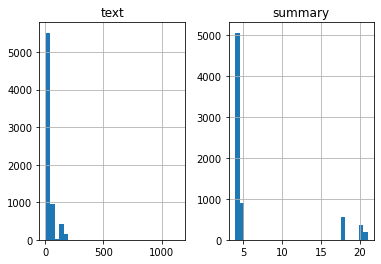

In [21]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleanedText']:
      text_word_count.append(len(i.split()))

for i in df['cleanedSummary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [22]:
max_len_text=300 
max_len_summary=50

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_tr,x_val,y_tr,y_val=train_test_split(df['cleanedText'],df['cleanedSummary'],test_size=0.1,random_state=0,shuffle=True) 

In [25]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [26]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [27]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

In [28]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [29]:
# Encoder 
encoder_inputs = Input(shape=(None,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 500)    10659000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 500),  2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [32]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
25/25 [==============================] - 41s 1s/step - loss: 1.2916 - val_loss: 0.3063
Epoch 2/50
25/25 [==============================] - 29s 1s/step - loss: 0.2753 - val_loss: 0.1835
Epoch 3/50
25/25 [==============================] - 30s 1s/step - loss: 0.1683 - val_loss: 0.1222
Epoch 4/50
25/25 [==============================] - 30s 1s/step - loss: 0.1268 - val_loss: 0.0520
Epoch 5/50
25/25 [==============================] - 30s 1s/step - loss: 0.0608 - val_loss: 0.0610
Epoch 00005: early stopping


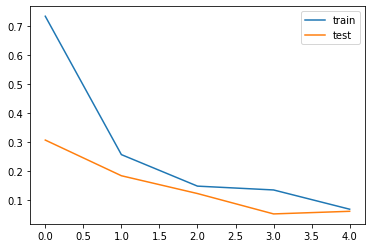

In [33]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [35]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [36]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        if sampled_token_index == 0:
            sampled_token_index = 1
        
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [38]:
for i in range(len(x_val)):  
    print("Claim:",seq2text(x_val[i]))
    print("\n")
    print("Original summary:",seq2summary(y_val[i]))
    print("\n")
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Claim: antibody antigen binding fragment antibody specifically binds hpcsk9 comprising a heavy chain complementarity determining region 1 comprising amino acid sequence least 95 seq id no 76 b heavy chain complementarity determining region 2 hcdr2 comprising amino sequence leaqt 95 identical seq id no 78 c heavy chain complementarity region 3 hcdr3 comprising amino sequence least 95 identical seq id no 80 d light chain complementarity determining region 1 lcdr1 comprising amino acid sequence least 95 identical seq id no 84 e chain complementarity determining region 2 lcdr2 comprising amino acid sequence least 95 seq id no 86 f light chain complementarity determining region 3 lcdr3 comprising acid sequence least 95 identical seq id no 88 2 antibody antigen binding fragment antibody claim 1 wherein antibody antigen binding antibody binds epitope comprising amino acid residue 238 hpcsk9 seq id no 755 


Original summary: 238 755 


Predicted summary:  238 755 start start start start start

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: multiple two bead bead variance due mutant wild type beads variance 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: alternatively completely isolated monoclonal antibody complex specifically binds pcsk9 wherein separated monoclonal antibody incorporated host pcsk9 epitope comprises least one pair residue 277 278 manufacturer seq andid no 8 wherein intermediate monoclonal anti

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibody tha6 binds pcdk9 in monoclonal antibody binds epitope comprising leas6 one 3 4 seq id no 5 wherein monoclonal antibody blocks nibding pcsk9 lwlr 


Original summary: 237 238 3 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: morbidity mor ibis group clearly thai pcsk9 i'unction diminished thc risk vascular disease 


Original summary: no data 


Predicted summary:  no data start start start start

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: binds pcsk9 wherein isol monoclonal binds epitope one residues 3 4 seq id no 5 w monoclonal hlocks binding pcsk9 ldlr 


Original summary: 237 238 3 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated antibody binds pcsk9 isolated monoclonal bind s epitope plcsk9 least one 237 238 seq id no 3 wherein mono clo binding pcsk9 ldlr 


Original summary: 237 238 3 


Predicted summary:  238 755 start star

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: fluorescent antibody pair without pcsk9 subtracted signal corresponding reaction containing pcsk9 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: dna and or protein incorporation estimated basis 35 for dna 125 for protein radioactivity recovered suspended pellets 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start sta

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: further genes comprising poly de sequences prov ded herein w thin scope present invention 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: calmied is 1 isloatde monoclonal antibody wherein boudn pcsk9 said monoclonal natiboyd binds least one ersideu iwthin esqunece set forth residues 123 132 seq id no 1 wherein said monoclonal antiobyd reduces binding psck9 egfa domain ldlr pr

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: denotes isolated human monoclonal antibody binds pcsk9 wherein isolated mutant monoclonal antibody binds epitope pcsk9 comprising least one page residues 277 part 278 seq id 8 7 wherein monoclonal antibody blocks binding affinity pcsk9 ldlr 


Original summary: 277 278 8 


Predicted summary:  237 238 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: ng also used derive antibodies mdent antibodies human antibody similar aml tlm mdent antibo

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibody antigen binding fragment antibody specifically binds hpcsk9 comprising a heavy chain complementarity determining region 1 hcdr1 comprising amino acid sequence i8 least 95 identical seq 1d no 76 b heavy chain complementarity determining region 2 hcdr2 comprising amino acid sequence least 95 identical seq id no 78 c heavy chain complementarity determining region 3 hcdr3 comprising amino acid sequence least 95 identica1 seq id no d light chain complementarity determining region 1 lcdr1 comprising amino acid sequence least 95 identical seq id no 84 e light chain complementarity determining region 2 lcdr2 compki8in9 amino acid sequence least 95 identical seq id no 86 f

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: specific embodiments present invention relates method treatment condition associated with pcsk9 activity condition functioning pcsk9 contraindicated particular subject comprises administering sub therapeutically effective amount pcsk9 specific antagonist present invention 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: thus one v h genes one h genes one j h genes mu constant 

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: results liposomal physical characteristics product dna and or protein entrapment particle size surface potential zeta summarized table 8 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: 0024 invention also comprises method reducing level ldl blood subject need thereof com administering subject therapeutically effective amount antibody prepared according invention 


Original s

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: invention lacimed is omnoclonal anitbdoy sepcificlayl bidns k2 domain kunitz domian 2 tfpi ewhrein said antibody specifically bidns petiope comprising residues e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 l50 seq id no 2 


Original summary: e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 l50 2 


Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: generally claimed 1 whereby 

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: presence murine rat derived proteins lead rapid clearance antibodies lead generation immune response antibody patient 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isoaltde monoclonal antibody bidns pcsk9 wehrien sioalted monoclaoln antibody binsd epitope comprising least one residues 3 4 seq id no 5 wherein nmoolconal atnibdoy bolcks bnidnig pcsk9 ldlr 


Original summary:

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: invention claimed is monoclonal antibody specifically binds kz domain kunitz domain 2 tfp1 whekein said antibody 8pecifica11y binds epitope comprising residues e10 b11 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 seq id no 2 


Original summary: e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 l50 2 


Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: particular amino acid v» v sequences ihe germline s

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: thus embodiments antigen binding proteins interact residues interact residues within 5 å residues contemplated provide useful inhibition pcsk9 binding ldlr 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibodies identified id05 suitable assays may tested ability antagonize neutralize i pcsk9 binding ldl tor and or ii pcsk9 internalization cells 


Original summary: no data

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: n terminal c terminal naturally occurring light heavy chain variable regions typically following order elements fr1 cdr1 fr2 cdr2 fr3 cdr3 fr4 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: invention claimed is omnocolanl natibdoy htat specificlaly binds k2 doamin kunizt domain 2 ftpi wherein said naitbody specifiacyll binds pietope comprising residues e10 e11 d12 p13 r17 y1

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: suitable peptide mimics group b polysaccharide g r molecular b epitopes 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: specific pcsk9 specific antagonists may carry detectable label may conjugated toxin e g radioactive radionuclide liposome targeting moiety biosensor cationic tail enzyme e g via bond linker 


Original summary: no data 


Predicted summary:  no data start st

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: iosltaed monoclonal antibody binds pcs9k whreien isolated onmocloanl antibody binds epitope pcsk9 comprising lesat one resiudse 237 238 seq id no 3 wherein monolconal antibody blocsk ibndign pcsk9 dllr 


Original summary: 237 238 3 


Predicted summary:  237 238 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isotlaed monoclonal antibody wherein boudn pcsk9 asid monoclonal antibody binds leats one residue within sequence set forth residu

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: competition binding members may readily assayed vitro example using elisa and or interaction antibodies pcsk9 solu tion 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: 0140 pcsk9 specific antagonist may adminis tered individual route administration appre ciated art including limited oral administra tion administration injection specific embodiments include intravenous subcuta

Predicted summary:  237 238 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: embodiments statin selected group consisting atorvastatin cerivastatin fluvastatin lovastatin mevastatin pitavastatin pravastatin rosuvastatin simvastatin combination thereof 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: hwat claimed is 1 iosltaed monoclonal antibody whreeni bound cpsk9 said monoclonal antibody binds least one residue within sequence set fotrh residues 123 132 

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: another embodiment invention provides antibody comprising specific vl cdri cdr2 and or cdr3 sequences variant thereof one conservative amino acid substitutions cdri cdr2 and cdr3 comprising vh complementary deter mining region cdri amino acid sequence shown seq idno 59 60 8 amino acid sequence shown seq id no 61 9 and or vh cdr3 amino acid sequence shown seq id no 10 variant thereof one conservative amino acid substitutions said sequences cdri cdr2 and or cdr3 wherein variant retains essentially bind ing specificity cdri cdr2 and or cdr3 defined said sequences 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start sta

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: used herein terms refers incorporation detectable marker e g incorporation amino acid attachment polypeptide biotin moieties detected marked avidin e g streptavidin containing fluorescent marker enzymatic activity detected optical colorimetric methods 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: claimed is monoclonal binds k2 domain munitz domaun 2 tfpi said specifically b

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: forest atcc vr 67 atcc vr 1247 ross river virus vr 373 atcc vr 1246 equine encephalitis atcc vr 923 atcc v r 1250 vr 1249 atcc vr 532 adeno associated virus aav vectors see e g pct publ 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: invention claimed monoclonal antibody specifically also binds residues k2 domain kunitz domain 2 members tfpi b wherein said antibody also speci

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: constant region may aglycosylated n linked glycosylation cally expression glycosylation deficient host cell 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monoclonal antibody wherein combined pcsk9 monoclonal antibody least one residue sequence residue 123 residue 132 id no 1 5 least one residue 132 combined monoclonal cancer antibodies reduced binding pcsk9 egfa do

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: certain exemplary activities functions molecule include limited to binding affinity enzymatic activity signal transduction 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: thc pcsk9 refers vanants ai least part activity pcsk9 unless indicated differently spccilic human pcsk9 


Original summary: no data 


Predicted summary:  no data start start start start start start start s

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monoclonal antibody wherein bound pcsk9 m0noc1ona1 antibody binds least one following residues s753 i154 p155 r194 0238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s3 1 8eq id no 3 wherein m0noc1ona1 antibody blocks binding pcsk9 ldlr 


Original summary: s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 


Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: thus assistor protein provide a

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: finally 40 μl well one step tmb neogen lexington ky added plate quenched 40 μl well 1n hydrochloric acid 30 minutes room temperature 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: wells treated blocking agent milk protein albumin prevent nonspecific adsorption analyte 


Original summary: no data 


Predicted summary:  no data start start start start start start start start 

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: certain embodiments pharmaceutical compositions include one different antigen binding protein pcsk9 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: wherein isolated monoclonal human antibody wherein bound pcsk9 said small monoclonal antibody binds least one recognition residue within sequence set forth residues 123 132 seq site id 1 wherein said monoclonal antibody partially 

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: biotech 7 4 1996 et al 13 2 222 245 et al 113 2 211 222 et al 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monoclonal wherein hound pcsk9 monoclonal antibody binds least one following residues s153 i154 p145 r194 d238 a239 i369 s372 d373 t37i c378 f379 v380 s381 seq id no 3 wherein monoclonal ant glocks binding pcskp ldkr 


Original summary: s153 i154 p155 r194 d

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: kits invention include one comprising pcsk9 antagonist antibody such human ized antibody peptide described herein instructions use accordance methods f invention described herein 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: instances antibodies include least one variable heavy chain one variable light chain listed table 2 


Original summary: no data 


Predicted summary: 

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibody antigen binding fragment antibody specifically binds hpcsk9 comprising a heavy chain complementarity determining region 1 hcdr1 comprising amino acid sequence least 95 identical seq id no 76 b heavy chain complementarity determining region 2 hcdr2 comprising amino acid sequence least 95 identical seq id no 78 c heavy chain complementarity determining region 3 hcdr3 comprising amino acid sequence least 95 identical 8eq id no 80 d light chain complementarity determining region 1 lcdr1 comprising amino acid sequence 1east 95 identical seq id no 84 e light chain complementarity determining region 2 lcdr2 comprising amino acid sequence least 95 identical t0 seq id no 86 f light chain

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: embodiments vh least 90 sequence identity amino acid sequence selected group consisting seq id no 74 85 71 72 67 87 58 52 51 53 48 54 55 56 49 57 50 91 64 62 89 65 79 80 76 77 78 83 69 81 60 and or vl least 90 sequence identity amino acid sequence selected group consisting seq id no 5 7 9 10 12 13 15 16 17 18 19 20 21 22 23 24 26 28 30 31 32 33 35 36 37 38 39 40 42 44 46 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start s

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monoclonal antibdyo whreien wehn boudn pcsk9 monoclonal antibody ibnds least one flolowign residues s153 i154 p155 r914 d238 a239 i369 s372 d374 c375 t377 c378 f739 v380 s381 seq id no 3 wherein monoclonal antibody blocks binding psck9 ldlr 


Original summary: s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 


Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: monoclonal antibody wherei

Predicted summary:  237 238 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monocloanl antibody binds pcs9k wherein isolated monoclonal atniobdy binsd epitope ocmpriisgn lesat one residues 3 4 seq id no 5 wherein mnooconlal antibody lbocks binding pcs9k lldr 


Original summary: 237 238 3 


Predicted summary:  237 238 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: embodiments first manner comprises first ec50 wherein second manner involves second ec50 wherein point mutation selected group consisting compri

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: pcsk9 zymogen occurs naureckiene et al 2003 shown required secretion cells seidah et al 2003 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: structures a xl tluee dimensional ons classes well known 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start sta

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: background invention 0004 people u s risk heart disease resulting events 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: claimed is monoclonal bfinds k2 domain kunitz domain 2 tifpi wherein saiod binds comprising es e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 l50 seq id no 2 


Original summary: e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: monoclonal antibody separated therein wherein small monoclonal antibody bonded least one identification residue sequence listed residue connection pcsk9 binds 132 seq site id no 1 and wherein monoclonal antibody portion reduces binding adjacent pcsk9 uses ldlr protein antagonize inhibition pcsk9 cell ldl intake 


Original summary: 123 132 10 


Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated rat m

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated monoclonal antibody whekein bound tu pcsk9 monoclonal antibody binds least one following residues s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 v380 s381 seq id no 3 wherein monoclonal antibody blocks binding pcsk9 lolr 


Original summary: s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 


Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: monoclonal antibody incompletely 

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: certain embodiments within included certain embodiments within 5 included 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: 0106 present invention encompasses nucleic acid encoding antibody molecules comprise i nucleic acid encoding light chain comprising seq id no spe cific embodiments comprise nucleic acid seq id no 2 ii nucleic acid encoding heavy chain compris ing seq id no

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: certain embodiments techniques ” ” used produce humanized antibodies 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: modified polypeptides made using established procedures art screened using standard assays known art described examples 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start sta

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: invention claimed monoclonal antibody specifically directly binds target k2 antibody domain central kunitz virus domain 2 tfpi wherein said antibody residue specifically binds epitope comprising residues e10 e11 d12 p13 r17 y19 t21 y23 f24 sequences n26 sequences q28 q31 c32 e33 r34 k36 l50 matrix seq id e 2 


Original summary: e10 e11 d12 p13 r17 y19 t21 y23 f24 n26 q28 q31 c32 e33 r34 k36 l50 2 


Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start sta

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: process combinatorial alanine scanning strategy used identify amino acids pcsk9 protein necessary interaction anti pcsk9 abps 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated wherein bound pcsk9 said monoclonal antibody binds least one residue sequence set forth ry idues 544 582 seq id no 90 saud monoclonal binding pcsp9 egfa domain protein antagonizes pcsk9 inhibitio

Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: and or cmss competing ant bodies encompassed useful meth ods disclosed hcrcin 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: independent isolated candidate monoclonal antibody wherein bound pcsk9 said monoclonal antibody binds length least one residue within sequence set forth determined residues 123 132 seq id chromosome 1 wherein said independent monoclonal antibody reduce

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: monoclonal antibody isolated wherein monoclonal antibody specifically binds least one residue generated seq id no no 123 132 seq id no part 1 combined pcsk9 and combination monoclonal antibody reduces binding pcsk9 egfa structural domain ldlr binding proteins antagonize inhibition pcsk9 normal cell ldl 


Original summary: 123 132 10 


Predicted summary:  123 132 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: actual separated monocl

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated antibody wherein pxcsk9 monoclonal antibody binds least one following residues s153 i154 p155 r194 d238 a239 s372 d374 c375 t377 c378 s3 81 seq id no 3 wherein monoclonal antibody blocks fpcsk9 


Original summary: s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 


Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibodies antigen binding fragments antibodies specifically binds hpcsk9 including a he

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: formulation capture elisa formulations immunisation table 2 assayed capture enzyme linked immunoadsorbent assay elisa ha a sichuan antigenicity 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: specific binding hpcsk9 antibody antigen binding identification fragment including a heavy chain complementary determination region 1 represented hcdr1 containing amino acid sequence ami

Predicted summary:  s153 i154 p155 r194 d238 a239 i369 s372 d374 c375 t377 c378 f379 v380 s381 3 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: example pcs k9 specific antagonists may used combination conjunction drugs therapeutic and or tic including limited cholesterol lowering drugs example cholesterol absorption inhibitors e g zetia cholesterol synthesis inhibitors e g zocor 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: certain embodiments humanized antibodies modified eliminate glycosylation sites order increase affinity ant

Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated antibody comprising heavy clmin variable region vi i mid light chain variable region vl h vi region comprises actd sequence slq id no 54 vl region comprises amino acid sequence sfq id 53 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: pcsk9 specific antagonists possessing one conservative amino acid substitutions retain ability selectively bind human pcsk9 antagonize

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: embodiments antibody positioned 5 angstroms less least two following residues pcsk9 s153 s188 i189 q190 s191 d192 r194 e197 g198 r199 v200 d224 r237 d238 k243 s373 d374 s376 t377 f379 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: isolated selective monoclonal antibody identified binds exclusively pcsk9 wherein already isolated monoclonal antibody binds epitope expressed pcs

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: aspects invention comprises method increasing ldlr protein levels subject administering subject effective amount least one isolated antigen binding protein described herein simultaneously sequentially agent elevates availability ldlr protein 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: 5 comprising mg ml 200 mg ml antibody mil limolar 100 millimolar histidine buffer 0 


O

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: such probable larger variations light chain cdrs possible without unduly interfering binding antigen binding protein pcsk9 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: antibody antigen binding fragment antibody specifically binds hpcsk9 comprising a heavy chain complementarity determining region 1 hcdr1 comprising amino acid sequence least 95 identical seq id no 76 b heavy

Predicted summary:  start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: embodiments include isolated pcsk9 specific antagonist and specific embodiments antibody molecules comprise light chain variable region sequence found seq id nos 57 60 optionally comprising heavy chain variable region sequence disclosed herein e g seq id no 11 specific embodiments inhibit human and or murine pcsk9 dependent inhibition cellular ldl uptake least 10'zo 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start st

Predicted summary:  238 755 start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start


Claim: 278 457 listing human framework regions said disclosure incor porated herein reference entirety 


Original summary: no data 


Predicted summary:  no data start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start




In [39]:
outF = open("myOutFile.txt", "w")

In [45]:
for i in range(len(x_val)):
    outF.write("Claim:" + seq2text(x_val[i]))
    outF.write("\n")
    outF.write("Original summary:" + seq2summary(y_val[i]))
    outF.write("\n")
    outF.write("Predicted summary:" + decode_sequence(x_val[i].reshape(1,max_len_text)))
    outF.write("\n")


In [46]:
outF.close()

In [47]:
claim = pd.Series([])
original = pd.Series([])
predicted = pd.Series([])

In [50]:
for i in range(len(x_val)):
    claim = claim.append(pd.Series(seq2text(x_val[i])), ignore_index=True) 
    original = original.append(pd.Series(seq2summary(y_val[i])), ignore_index=True) 
    predicted = predicted.append(pd.Series(decode_sequence(x_val[i].reshape(1,max_len_text))), ignore_index=True) 

In [51]:
claimArray = claim.array
originalArray = original.array
predictedArray = predicted.array

In [52]:
dataMatrix = np.column_stack((claimArray, originalArray, predictedArray))

In [53]:
pd.DataFrame(dataMatrix).to_csv("Summarization.csv", index=False, header=False)